## Homework Week 4

### Data Preparation

In [1]:
import numpy as np
import pandas as pd

In [2]:
columns = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']

In [3]:
# Load csv to pandas dataframework
df = pd.read_csv('car_price.csv')

In [4]:
# Shortlist columns
df = df[columns]

In [5]:
# Uniform columns name
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
# Uniform categorical data values
categorical = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [7]:
# Check missing values
df.shape[0] - df.notnull().sum()
# categorical ['make', 'model', 'transmission_type', 'vehicle_style']

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [8]:
# Fill missing values
col_with_null = (df.shape[0] - df.notnull().sum()) > 0
col_with_null = list(df[df.columns[col_with_null]].columns)
df[col_with_null] = df[col_with_null].fillna(0)
df.shape[0] - df.notnull().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [9]:
msrp_avg = df['msrp'].mean()
df['above_average'] = df.apply(lambda x: 1 if x['msrp'] > msrp_avg else 0, axis=1)
del df['msrp']

In [10]:
df

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0
...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11910,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11911,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11912,acura,zdx,2013,300.0,6.0,automatic,4dr_hatchback,23,16,1


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Split data into 3 parts: train/validation/test with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_test), len(df_val)

(7148, 2383, 2383)

In [13]:
# Split data sets into features and target
y_train = df_train.above_average
y_val = df_val.above_average
y_test = df_test.above_average
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 1: ROC AUC feature importance

In [14]:
numerical = list(df_train.dtypes[df_train.dtypes != 'object'].index)
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [16]:
# Calculate the ROC AUC for each numerical feature
roc_auc = []
for numeric in numerical:
    model = LogisticRegression()
    model.fit(df_train[numeric].to_frame(), y_train)
    y_pred = model.predict(df_val[numeric].to_frame())
    roc_auc.append(roc_auc_score(y_val, y_pred))

In [17]:
roc_auc_values = list(zip(numerical, roc_auc))
roc_auc_values

[('year', 0.5),
 ('engine_hp', 0.7966431604770571),
 ('engine_cylinders', 0.6923457196272261),
 ('highway_mpg', 0.5),
 ('city_mpg', 0.5022935779816514)]

In [18]:
# Get the higher value numerical feature
roc_auc_values.sort(key=lambda x: x[1], reverse=True)
print ('Higher feature is **%s** with value of **%.3f**' % (roc_auc_values[0][0], roc_auc_values[0][1]))

Higher feature is **engine_hp** with value of **0.797**


### Question 2: Training the model

In [19]:
from sklearn.feature_extraction import DictVectorizer

In [20]:
# Apply one-hot-encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
features = numerical + categorical

train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [21]:
# Fitting the model using logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [22]:
# Predicting the model using the validation set
y_pred = model.predict_proba(X_val)[:,1]
y_pred

array([0.66923759, 0.00692016, 0.34113734, ..., 0.00419114, 0.99999409,
       0.05309672])

In [23]:
from sklearn.metrics import auc

In [24]:
# Using the scikit learn funtion "roc_curve" we obtain the FPR and TPT
fpr, tpr, _ = roc_curve(y_val, y_pred)

In [25]:
# Finally, we get the AUC value
print ('The AUC value is **%.3f**' % auc(fpr, tpr))

The AUC value is **0.979**


### Question 3: Precision and Recall

In [26]:
# Let's see for all of the possible thresholds values
def calc_scores(y_val, y_pred):
    scores = []
    thresholds = np.arange(0, 1.01, 0.01)

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    for t in thresholds:
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        # compute precision and recall
        precision = tp / (tp + fp)
        recall  = tp / (tp + fn)
        F1 = 2 *  precision * recall / (precision + recall)

        scores.append((t, tp, tn, fp, fn, precision, recall, F1))
    return scores

In [27]:
columns = ['thresholds', 'tp', 'tn', 'fp', 'fn', 'precision', 'recall', 'F1']
df_scores = pd.DataFrame(calc_scores(y_val, y_pred), columns=columns)
df_scores[::10]

/tmp/ipykernel_11442/2735274939.py:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


,thresholds,tp,tn,fp,fn,precision,recall,F1
0,0.0,654,0,1729,0,0.274444,1.000000,0.430688
10,0.1,644,1398,331,10,0.660513,0.984709,0.790669
20,0.2,623,1529,200,31,0.756987,0.952599,0.843602
30,0.3,607,1589,140,47,0.812584,0.928135,0.866524
40,0.4,590,1625,104,64,0.850144,0.902141,0.875371
50,0.5,569,1659,70,85,0.890454,0.870031,0.880124
60,0.6,550,1679,50,104,0.916667,0.840979,0.877193
70,0.7,507,1702,27,147,0.949438,0.775229,0.853535
80,0.8,466,1713,16,188,0.966805,0.712538,0.820423
90,0.9,376,1726,3,278,0.992084,0.574924,0.727977


In [28]:
import matplotlib.pyplot as plt

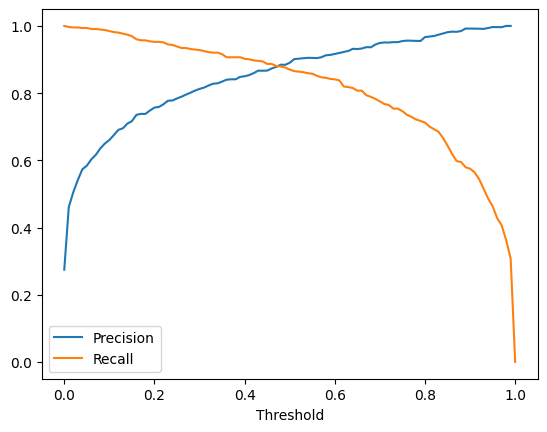

In [29]:
plt.plot(df_scores.thresholds, df_scores.precision, label='Precision')
plt.plot(df_scores.thresholds, df_scores.recall, label='Recall')
plt.legend()
plt.xlabel('Threshold');

In [30]:
df_scores[['thresholds', 'precision', 'recall']][45:51].round(2)

,thresholds,precision,recall
45,0.45,0.87,0.89
46,0.46,0.87,0.89
47,0.47,0.88,0.88
48,0.48,0.88,0.88
49,0.49,0.88,0.88
50,0.50,0.89,0.87


<u>**Answer**</u>: at **threshold = 0.48** precision and recall curves intersect

### Question 4: F1 score

In [31]:
t_max_F1 = df_scores.iloc[df_scores['F1'].idxmax()]['thresholds']
print ('The threshold at the max F1 value is **%s**' % (t_max_F1))

The threshold at the max F1 value is **0.51**


### Question 5: 5-Fold CV

In [32]:
from sklearn.model_selection import KFold

In [33]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [34]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [35]:
def auc_scores(n_splits, C=1.0):
    
    scores = []
    # instantiate the KFold class
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        # split the data
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        # train the model
        dv, model = train(df_train, y_train, C)
        # predict the model
        y_pred = predict(df_val, dv, model)

        # calculate the AUC
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    return scores

In [36]:
n_splits = 5
C = 1
scores = auc_scores(n_splits, C)
print('The Standard Deviation is ** %.3f **' % (np.std(scores)))

The Standard Deviation is ** 0.003 **


### Question 6: Hyperparameter Tuning

In [37]:
n_splits = 5
for C in [0.01, 0.1, 0.5, 10]:
    scores = auc_scores(n_splits, C)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.001
C=10 0.983 +- 0.003


<u>**Answer**</u>: the C that leads to the best score is **C=10**